# Capstone Two: EDA

In this step for my capstone, I am going to examine the data to find some initial hypotheses and relationships in the data. 

The general plan for this notebook will be: 

1. Import the data.
2. What stores are selling the most, and where are they located? 
3. What item and which item category are most popular? 
4. Is the general trend of the sales rising or falling? Do day of the week or month impact sales?
5. What days see a spike in sales, or a lack of sales, relative to the moving average? 

# 1. Import the data

In [1]:
# import libraries and format output
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import itertools
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression

import warnings
#warnings.filterwarnings('ignore')

import os
from library.sb_utils import save_file
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df = pd.read_csv("./data/training_data_cleaned.csv")

In [3]:
df.shape

(2935843, 10)

In [4]:
df.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-01-03,0,25,2552,899.00,1.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-01-05,0,25,2552,899.00,-1.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-01-06,0,25,2554,1709.05,1.00,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.00,1.00,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""
5,2013-01-10,0,25,2564,349.00,1.00,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,"Москва ТРК ""Атриум"""
6,2013-01-02,0,25,2565,549.00,1.00,DEEP PURPLE Stormbringer (фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""
7,2013-01-04,0,25,2572,239.00,1.00,DEFTONES Koi No Yokan,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
8,2013-01-11,0,25,2572,299.00,1.00,DEFTONES Koi No Yokan,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
9,2013-01-03,0,25,2573,299.00,3.00,DEL REY LANA Born To Die,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935843 entries, 0 to 2935842
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   item_name           object 
 7   item_category_id    int64  
 8   item_category_name  object 
 9   shop_name           object 
dtypes: float64(2), int64(4), object(4)
memory usage: 224.0+ MB


In [6]:
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d', errors='coerce')

In [7]:
df.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

In [8]:
df.dtypes

date                  datetime64[ns]
date_block_num                 int64
shop_id                        int64
item_id                        int64
item_price                   float64
item_cnt_day                 float64
item_name                     object
item_category_id               int64
item_category_name            object
shop_name                     object
dtype: object

# 2. What stores are selling the most, and where are they located? 

In [9]:
grouped_shop = pd.DataFrame(df.groupby(['shop_id', 'date_block_num', 'date'])['item_cnt_day'].sum().reset_index())
grouped_shop.columns =['shop_id','date_block_num','date','item_cnt_month']

In [10]:
grouped_shop.head()

,shop_id,date_block_num,date,item_cnt_month
0,0,0,2013-01-03,203.00
1,0,0,2013-01-04,352.00
2,0,0,2013-01-05,292.00
3,0,0,2013-01-06,209.00
4,0,0,2013-01-07,132.00


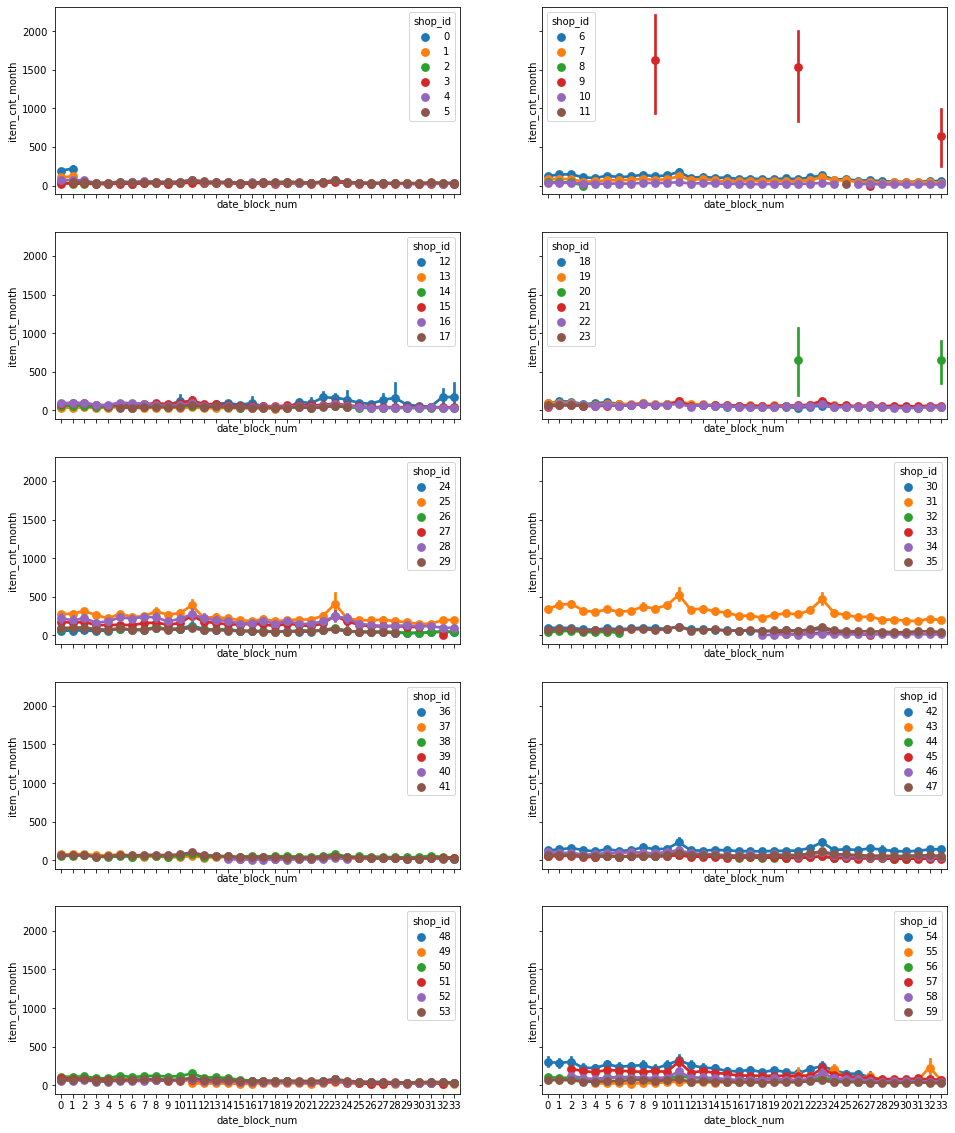

In [11]:
from math import ceil
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped_shop.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_month', hue='shop_id', data=grouped_shop[np.logical_and(count*id_per_graph <= grouped_shop['shop_id'], grouped_shop['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

From this, we can see a few very important things. We can see that some shops only sold for certain months and then did not sell again; some sales are declining consistently; there is a peak near the holiday season. Adding month data will help find patterns like holiday seasonal purchases. 

In [12]:
df['month'] = [int(d.strftime('%m')) for d in df.date]
months = df.month.unique()

print(months)

[ 1  2  3  4  5  6  7  8  9 10 11 12]


Some stores stand out as well. Stores 9, 12, 20, 25, 31, and some of the highest shop ids stand out on these graphs. Let's look at the stores that had the best month sales. 

In [13]:
grouped_shop.groupby('shop_id')['item_cnt_month'].max().sort_values(ascending=False).head(10)

shop_id
9    2279.00
12   2259.00
25   1966.00
55   1298.00
20   1150.00
31   1080.00
42    834.00
54    818.00
57    730.00
27    715.00
Name: item_cnt_month, dtype: float64

Stores 9, 12, 20, 25, 31, and 55 had the best selling months! Where are these stores located? 

In [14]:
shop_id_list = [9, 12, 20, 25, 31, 55]
for shop in shop_id_list: 
    print(df[df.shop_id == shop].shop_name.unique())

['Выездная Торговля']
['Интернет-магазин ЧС']
['Москва "Распродажа"']
['Москва ТРК "Атриум"']
['Москва ТЦ "Семеновский"']
['Цифровой склад 1С-Онлайн']


At least 3 of these are in Moscow (Москва), fairly close to the center of the city. Цифровой склад 1С-Онлайн and Интернет-магазин ЧС are a digital online stores/warehouses. 
Выездная Торговля translates to Outbound Trade, meaning that these items could be distributed to other stores or exported internationally. 

### Which stores had the best averages sales per month? 

In [15]:
grouped_shop.groupby('shop_id')['item_cnt_month'].mean().sort_values(ascending=False).head(10)

shop_id
9    1133.29
20    652.44
31    301.43
25    234.87
54    224.93
0     205.35
28    178.83
27    152.01
57    145.17
42    140.30
Name: item_cnt_month, dtype: float64

In [16]:
print(df[df.shop_id == 54].shop_name.unique())

['Химки ТЦ "Мега"']


Aside from our usual list, 54 shows up - it is a shopping center in Moscow, though more on the outer edges of the city. No surprises! 

#####  The stores that sell the most are either online or in Moscow. 

# 3. What item and which item category are most popular?

In [17]:
grouped_item_cat = pd.DataFrame(df.groupby(['item_category_id', 'date_block_num', 'date'])['item_cnt_day'].sum().reset_index())
grouped_item_cat.columns =['item_category_id','date_block_num','date','item_cnt_month']

In [18]:
grouped_item_cat.head()

,item_category_id,date_block_num,date,item_cnt_month
0,0,0,2013-01-10,1.00
1,0,1,2013-02-28,1.00
2,0,3,2013-04-02,1.00
3,1,0,2013-01-10,1.00
4,1,1,2013-02-20,1.00


In [19]:
grouped_item_cat.groupby('item_category_id')['item_cnt_month'].max().sort_values(ascending=False).head(10)

item_category_id
30   4286.00
19   2691.00
20   2331.00
9    2185.00
28   2060.00
40   2049.00
12   1584.00
23   1320.00
80   1268.00
8    1210.00
Name: item_cnt_month, dtype: float64

In [20]:
item_cat_list = [30, 19, 20, 9, 28, 40]
for item in item_cat_list: 
    print(df[df.item_category_id == item].item_category_name.unique())

['Игры PC - Стандартные издания']
['Игры - PS3']
['Игры - PS4']
['Доставка товара']
['Игры PC - Дополнительные издания']
['Кино - DVD']


All of the top selling categories are Games, aside from the movie DVD and the Delivery of goods category. 

In [21]:
grouped_item = pd.DataFrame(df.groupby(['item_id', 'date_block_num', 'date'])['item_cnt_day'].sum().reset_index())
grouped_item.columns =['item_id','date_block_num','date','item_cnt_month']
grouped_item.groupby('item_id')['item_cnt_month'].max().sort_values(ascending=False).head(10)

item_id
3731    3825.00
11373   2169.00
3732    2144.00
10209   2005.00
1849    1863.00
10210   1804.00
2814    1752.00
6675    1584.00
16790   1519.00
7807    1426.00
Name: item_cnt_month, dtype: float64

In [22]:
item_list = [3731, 11373, 3732, 10209]
for item in item_list: 
    print(df[df.item_id == item].item_name.unique())

['Grand Theft Auto V [PC, русские субтитры]']
['Доставка до пункта выдачи (Boxberry)']
['Grand Theft Auto V [PS3, русские субтитры]']
['Ведьмак 3: Дикая охота [PC, русская версия]']


Aside from shipping, the top 3 items sold on a single day are video games - Grand Theft Auto V PC, Grand Theft Auto V PS3, The Witcher 3: Wild Hunt PC. 

##### The most popular items are Grand Theft Auto V PC, Grand Theft Auto V PS3, The Witcher 3: Wild Hunt PC. The most popular category is games. 

# 4. Is the general trend of the sales rising or falling? Do day of the week or month impact sales?

In [23]:
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

best fit line:
y = 139368.15 + -1943.52x


C:\Users\cfran\AppData\Local\Temp/ipykernel_18848/2705160908.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ts=df.groupby(["date_block_num"])["item_cnt_day","date_block_num"].sum()


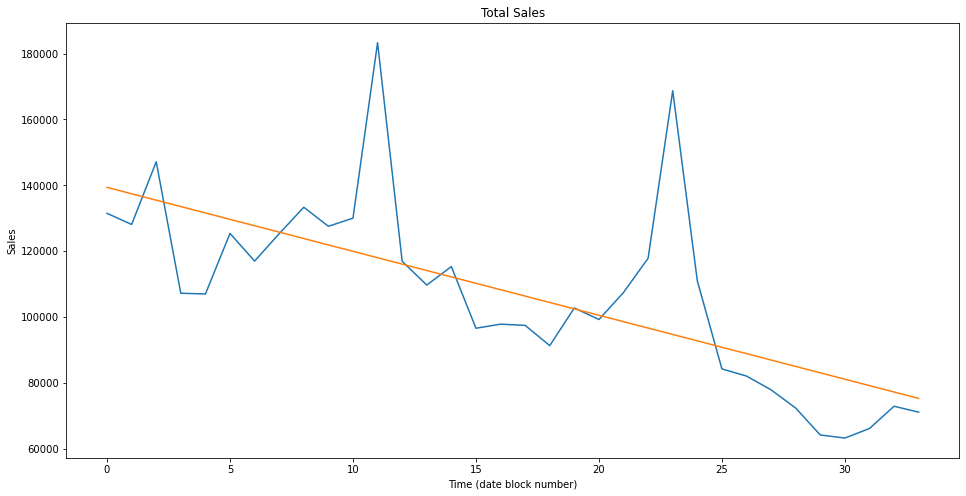

In [24]:
ts=df.groupby(["date_block_num"])["item_cnt_day","date_block_num"].sum()
ts.date_block_num = ts.index

a, b = best_fit(ts.date_block_num, ts.item_cnt_day)
yfit = [a + b * xi for xi in ts.date_block_num]

plt.figure(figsize=(16,8))
plt.plot(ts.item_cnt_day);
plt.title('Total Sales')
plt.xlabel('Time (date block number)')
plt.ylabel('Sales')

plt.plot(ts.date_block_num, yfit)

There is a very clear negative slope with time - sales are definitely decreasing with time. There also appears to be a cyclical nature, where the sales spike at the end of the year. This confirms what we saw earlier. 

Let's see if I can isolate the periodicity. 

In [25]:
grouped_shop = grouped_shop.set_index(grouped_shop['date'])
del grouped_shop['date']
y = grouped_shop['item_cnt_month'].resample('MS').sum()

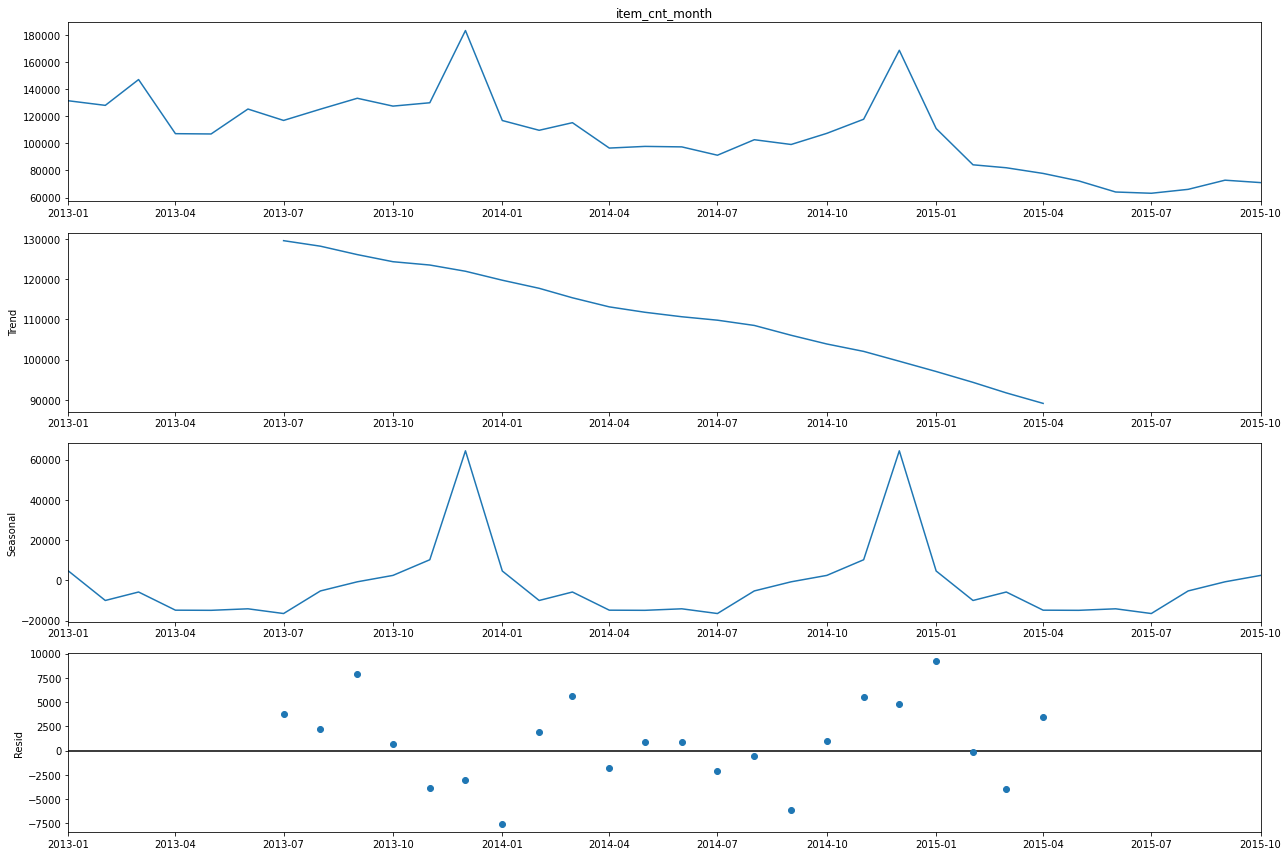

In [26]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 12
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Here we see the seasonal nature to the data and the downward trend. 

Does day of the week matter? 

In [27]:
df['day_of_week'] = df.date.dt.dayofweek
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,month,day_of_week
0,2013-01-02,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",1,2
1,2013-01-03,0,25,2552,899.00,1.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,3
2,2013-01-05,0,25,2552,899.00,-1.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,5
3,2013-01-06,0,25,2554,1709.05,1.00,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,6
4,2013-01-15,0,25,2555,1099.00,1.00,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",1,1


In [28]:
grouped_weekday = pd.DataFrame(df.groupby(['day_of_week'])['item_cnt_day'].sum().reset_index())
grouped_weekday.head(10)

,day_of_week,item_cnt_day
0,0,401487.00
1,1,454985.00
2,2,439713.00
3,3,454622.00
4,4,553455.00
5,5,734646.00
6,6,609292.00


In [29]:
print(grouped_weekday[grouped_weekday.day_of_week >= 5].mean())
print(grouped_weekday[grouped_weekday.day_of_week <= 4].mean())

day_of_week         5.50
item_cnt_day   671969.00
dtype: float64
day_of_week         2.00
item_cnt_day   460852.40
dtype: float64


In [30]:
grouped_weekday.corr()

,day_of_week,item_cnt_day
day_of_week,1.00,0.84
item_cnt_day,0.84,1.00


##### Not only is the general trend falling, there is a distinct seasonality to the data. Weekends also see more sales - by an average of about 211,116 per day.

# 5. What days see a spike in sales, or a lack of sales, relative to the moving average? 

In [31]:
dts=df.groupby(["date"])["item_cnt_day"].sum()
moving14 = dts.rolling(14, center=True).mean()

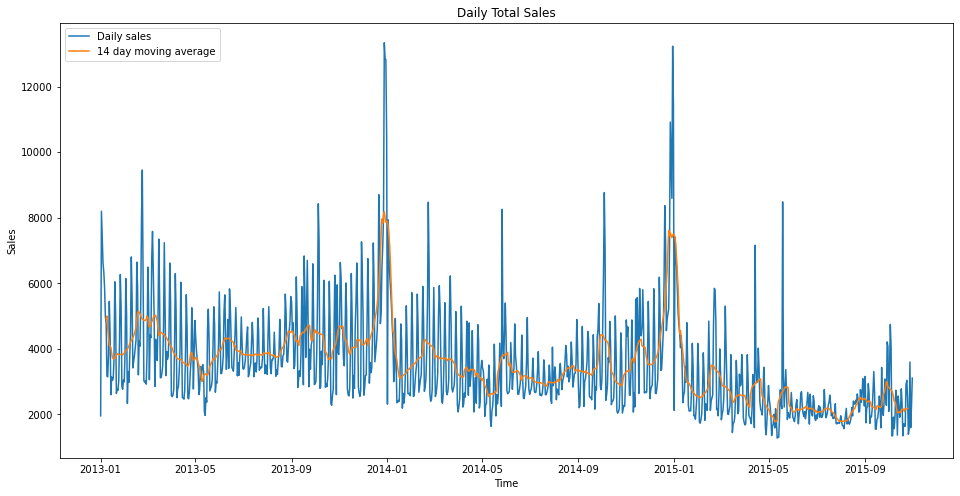

In [32]:
plt.figure(figsize=(16,8))
plt.title('Daily Total Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(dts, label="Daily sales")
plt.plot(moving14, label="14 day moving average")
plt.legend(loc=2)

In [33]:
diff14 = dts-moving14
diff14 = diff14.abs()
diff14 = diff14.sort_values(ascending = False)
diff14[diff14 > 3*moving14.std()].index

DatetimeIndex(['2015-05-19', '2014-12-30', '2014-01-01', '2015-01-01',
               '2013-12-28', '2013-12-30', '2013-12-29', '2013-02-23',
               '2014-05-27', '2014-10-04', '2014-02-22', '2015-04-14',
               '2013-10-05', '2014-12-31', '2014-12-27'],
              dtype='datetime64[ns]', name='date', freq=None)

Here we see the 15 values that fall outside of 3 times the standard deviation. There is a lot of deviation in the numbers already, so choosing 3 allows us to make sure we see only very extreme values. 

Some of the days are obvious holidays: date around new years stand out. February 22-23 also stands out; Defender of the Fatherland Day has a large influence on this data. Exclusing those, we see 2015-05-19, 2014-05-27, 2014-10-04, 2015-04-14, and 2013-10-05 as days of the largest deviance. Let's examine those days. 

In [34]:
daily_max = []
for day in ['2015-05-19', '2014-05-27', '2014-10-04', '2015-04-14', '2013-10-05']: 
    daily_max.append((day, df[df.date == day].groupby('item_name')["item_cnt_day"].sum().max()))
    print(day)
    print(df[(df.date == day) & (df.item_cnt_day > 40)].item_name.unique())
    print(df[(df.date == day) & (df.item_cnt_day > 40)].item_category_name.unique())

2015-05-19
['Ведьмак 3: Дикая охота [PC, русская версия]'
 'Ведьмак 3: Дикая охота [PS4, русская версия]'
 'Ведьмак 3: Дикая охота. Коллекционное издание [PC, русская версия]'
 'Ведьмак 3: Дикая охота. Коллекционное издание [PS4, русская версия]'
 'Курьерская доставка (Boxberry)' 'Доставка (EMS)' 'Доставка (по Москве)'
 'Доставка до пункта выдачи (Boxberry)' 'Доставка (Почта)'
 'Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм'
 'Энциклопедия Мир Ведьмака']
['Игры PC - Дополнительные издания' 'Игры - PS4'
 'Игры PC - Коллекционные издания' 'Доставка товара'
 'Подарки - Сумки, Альбомы, Коврики д/мыши'
 'Книги - Артбуки, энциклопедии']
2014-05-27
['Watch_Dogs. Специальное издание [PS4, русская версия]'
 'Watch_Dogs. Специальное издание [PC, русская версия]'
 'Watch_Dogs. Dedsec Edition [PC, русская версия]'
 'Watch_Dogs. Vigilante Edition [PC, русская версия]'
 'Доставка (по Москве)' 'Доставка (Почта)'
 'Доставка до пункта выдачи (Boxberry)']
['Игры - PS4' 'Игры PC - Дополнительные 

Running this through google translate, we can see that the best selling items are all video game or computer related - using NLP, we could sharpen our machine learning with categories that capture this feature, including a category for 'major video game release planned', but for now I am going to pass on this.

The top dates do have some pattern: the new year tends to have spikes high or low; video game releases for large name games (The Witcher 3, etc) also spike; 2013-02-23/2014-02-22 and the fact that this data is Russian indicate that Defender of the Fatherland Day has a large influence. Finally, new years also has a large influence. 

##### Holidays, specifically new year and Defender of the Fatherland Day, play a large role. The other largest factor is video game release days for major releases (AAA title games). 